## 准备工作

1.确保您按照[README](README-CN.md)中的说明在环境中设置了API密钥

2.安装依赖包

In [1]:
!pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

## 1. 生成 Embedding (基于 text-embedding-ada-002 模型)

嵌入对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

![Embedding](images/embedding-vectors.svg)

### 电动汽车注册数据集(Electric Vehicle Registration Dataset)

Source:[电动汽车注册数据集](https://www.kaggle.com/datasets/venkatsairo4899/ev-population-data)

![dataset](images/EV-Registration-Dataet.png)


该数据集包含华盛顿州注册局在册的电动（Battery Electric Vehicles）和混动（Plug-in Hybrid Electric Vehicles）汽车信息。

我们将把评论摘要和正文合并成一个单一的组合文本。模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

In [2]:
# 导入 pandas 包。Pandas 是一个用于数据处理和分析的 Python 库
# 提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd
# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken
# 从 openai.embeddings_utils 包中导入 get_embedding 函数。
# 这个函数可以获取 GPT-3 模型生成的嵌入向量。
# 嵌入向量是模型内部用于表示输入数据的一种形式。
from openai.embeddings_utils import get_embedding

#### 加载数据集

In [167]:
input_datapath = "data/Electric_Vehicle_Population_Data.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Model Year", "Make", "Model", "Electric Vehicle Type", "Clean Alternative Fuel Vehicle (CAFV) Eligibility", "Electric Range", "State"]]
df = df.dropna()

# 将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df["combined"] = (
    "Model: " + df.Model.str.strip() + "; EV Type: " + df.iloc[:,3].str.strip() + "; Clean: " + df.iloc[:,4].str.strip() + "; Range: " + df["Electric Range"].astype(str).str.strip()
)
df.head(2)

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,State,combined
VIN (1-10),,,,,,,,
1N4AZ0CP5D,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,WA,Model: LEAF; EV Type: Battery Electric Vehicle...
1N4AZ1CP8K,2019,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,150,WA,Model: LEAF; EV Type: Battery Electric Vehicle...


In [168]:
df["combined"][0]

'Model: LEAF; EV Type: Battery Electric Vehicle (BEV); Clean: Clean Alternative Fuel Vehicle Eligible; Range: 75'

#### Embedding 模型关键参数

In [169]:
# 模型类型
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000  

#### 将样本减少到最近的1,000个评论，并删除过长的样本


In [174]:
# 设置要筛选的评论数量为1000
top_n = 1000
# 对DataFrame进行排序，基于"Time"列，然后选取最后的2000条评论。
# 这个假设是，我们认为最近的评论可能更相关，因此我们将对它们进行初始筛选。
df = df.sort_values(by=["Make", "Model Year", "Model", "State"], ascending=False).tail(top_n * 3) 
# 丢弃"Time"列，因为我们在这个分析中不再需要它。
#df.drop("Model Year", axis=1, inplace=True)
# 从'embedding_encoding'获取编码
encoding = tiktoken.get_encoding(embedding_encoding)

# 计算每条评论的token数量。我们通过使用encoding.encode方法获取每条评论的token数，然后把结果存储在新的'n_tokens'列中。
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

# 如果评论的token数量超过最大允许的token数量，我们将忽略（删除）该评论。
# 我们使用.tail方法获取token数量在允许范围内的最后top_n（1000）条评论。
df = df[df.n_tokens <= max_tokens].tail(top_n)

# 打印出剩余评论的数量。
len(df)

1000

In [175]:
df.head(200)

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,State,combined,n_tokens
VIN (1-10),,,,,,,,,
1W9WL21BXA,2010,WHEEGO ELECTRIC CARS,WHEEGO,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,100,WA,Model: WHEEGO; EV Type: Plug-in Hybrid Electri...,33
1W9WL21B6A,2010,WHEEGO ELECTRIC CARS,WHEEGO,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,100,WA,Model: WHEEGO; EV Type: Plug-in Hybrid Electri...,33
1W9WL21B6A,2010,WHEEGO ELECTRIC CARS,WHEEGO,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,100,WA,Model: WHEEGO; EV Type: Plug-in Hybrid Electri...,33
YV4BR0CZ5N,2022,VOLVO,XC90,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,18,GA,Model: XC90; EV Type: Plug-in Hybrid Electric ...,32
7JRBR0FL1N,2022,VOLVO,S60,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,22,MT,Model: S60; EV Type: Plug-in Hybrid Electric V...,32
...,...,...,...,...,...,...,...,...,...
5YJSA1S21F,2015,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,AZ,Model: MODEL S; EV Type: Battery Electric Vehi...,28
5YJSA1H16E,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,CA,Model: MODEL S; EV Type: Battery Electric Vehi...,28
5YJSA1CG3D,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,CA,Model: MODEL S; EV Type: Battery Electric Vehi...,28


#### 生成 Embeddings 并保存（非必须步骤，可直接复用项目中文件）

In [176]:
# 实际生成会耗时几分钟
# 提醒：非必须步骤，可直接复用项目中的嵌入文件 fine_food_reviews_with_embeddings_1k
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

output_datapath = "data/ev_registration_with_embeddings_1k_2146.csv"

df.to_csv(output_datapath)

## 2.读取 fine_food_reviews_with_embeddings_1k 嵌入文件

In [177]:
embedding_datapath = "data/ev_registration_with_embeddings_1k_2146.csv"

df_embedded = pd.read_csv(embedding_datapath, index_col=0)

#### 查看 Embedding 结果

In [178]:
df_embedded["embedding"]

VIN (1-10)
1W9WL21BXA    [0.027527090162038803, -0.016709953546524048, ...
1W9WL21B6A    [0.027527090162038803, -0.016709953546524048, ...
1W9WL21B6A    [0.027527090162038803, -0.016709953546524048, ...
YV4BR0CZ5N    [0.015543443150818348, -0.020742183551192284, ...
7JRBR0FL1N    [0.01142300944775343, -0.010459070093929768, 0...
                                    ...                        
WA1AAAGE3P    [0.018343627452850342, -0.03631985932588577, 0...
WA1VABGE1P    [0.018343627452850342, -0.03631985932588577, 0...
WA1VABGE7M    [0.009440302848815918, -0.017417194321751595, ...
WAUUPBFF9H    [0.011015095748007298, 0.0011914892820641398, ...
WAUTPBFF5H    [0.011015095748007298, 0.0011914892820641398, ...
Name: embedding, Length: 1000, dtype: object

In [21]:
len(df_embedded["embedding"][0])

34440

In [22]:
type(df_embedded["embedding"][0])

str

In [83]:
df_embedded["embedding"][0]

'[0.012507181614637375, -0.028640011325478554, 0.02757057547569275, 0.010485687293112278, -0.048489782959222794, 0.01984977163374424, -0.024023178964853287, -0.015324232168495655, -0.0019106382969766855, -0.0379258431494236, -0.0022953744046390057, 0.04415987432003021, -0.01751527190208435, -0.022810282185673714, -0.004470111336559057, -0.0009194539161399007, 0.0008493537316098809, -0.018871629610657692, 0.02245815098285675, -0.004861368332058191, -0.025575164705514908, 0.0006443513557314873, -0.009227144531905651, 0.009977053850889206, 0.025170866400003433, 0.013328821398317814, 0.010035742074251175, -0.013980916701257229, 0.001969326985999942, 0.01879337802529335, 0.017971737310290337, 0.005229801870882511, -0.01601545326411724, -0.025144783779978752, -0.000166182333487086, -0.020136693492531776, 0.003987560980021954, 0.001574809430167079, 0.0372476652264595, -0.022562487050890923, 0.005656924098730087, 0.021114835515618324, -0.01193985901772976, -0.002921385457739234, -0.01966718584

In [179]:
import ast

# 将字符串转换为向量
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

In [133]:
len(df_embedded["embedding_vec"][0])

1536

In [209]:
df_embedded.head(200)

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,State,combined,n_tokens,embedding,embedding_vec,Cluster,similarity
VIN (1-10),,,,,,,,,,,,,
1W9WL21BXA,2010,WHEEGO ELECTRIC CARS,WHEEGO,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,100,WA,Model: WHEEGO; EV Type: Plug-in Hybrid Electri...,33,"[0.027527090162038803, -0.016709953546524048, ...","[0.027527090162038803, -0.016709953546524048, ...",0,0.836176
1W9WL21B6A,2010,WHEEGO ELECTRIC CARS,WHEEGO,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,100,WA,Model: WHEEGO; EV Type: Plug-in Hybrid Electri...,33,"[0.027527090162038803, -0.016709953546524048, ...","[0.027527090162038803, -0.016709953546524048, ...",0,0.836176
1W9WL21B6A,2010,WHEEGO ELECTRIC CARS,WHEEGO,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,100,WA,Model: WHEEGO; EV Type: Plug-in Hybrid Electri...,33,"[0.027527090162038803, -0.016709953546524048, ...","[0.027527090162038803, -0.016709953546524048, ...",0,0.836176
YV4BR0CZ5N,2022,VOLVO,XC90,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,18,GA,Model: XC90; EV Type: Plug-in Hybrid Electric ...,32,"[0.015543443150818348, -0.020742183551192284, ...","[0.015543443150818348, -0.020742183551192284, ...",0,0.745533
7JRBR0FL1N,2022,VOLVO,S60,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,22,MT,Model: S60; EV Type: Plug-in Hybrid Electric V...,32,"[0.01142300944775343, -0.010459070093929768, 0...","[0.01142300944775343, -0.010459070093929768, 0...",0,0.742270
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5YJSA1S21F,2015,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,AZ,Model: MODEL S; EV Type: Battery Electric Vehi...,28,"[0.010144701227545738, -0.0040008206851780415,...","[0.010144701227545738, -0.0040008206851780415,...",1,0.736950
5YJSA1H16E,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,CA,Model: MODEL S; EV Type: Battery Electric Vehi...,28,"[0.010144701227545738, -0.0040008206851780415,...","[0.010144701227545738, -0.0040008206851780415,...",1,0.736950
5YJSA1CG3D,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,CA,Model: MODEL S; EV Type: Battery Electric Vehi...,28,"[0.010144701227545738, -0.0040008206851780415,...","[0.010144701227545738, -0.0040008206851780415,...",1,0.736950


## 3. 使用 t-SNE 可视化 1536 维 Embedding 美食评论

In [181]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [136]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [182]:
# 首先，确保你的嵌入向量都是等长的
assert df_embedded['embedding_vec'].apply(len).nunique() == 1

In [183]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedded['embedding_vec'].values)

In [184]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [185]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [186]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [187]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded["Electric Range"].values

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embedded["Electric Range"].values)

In [214]:
color_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 3,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

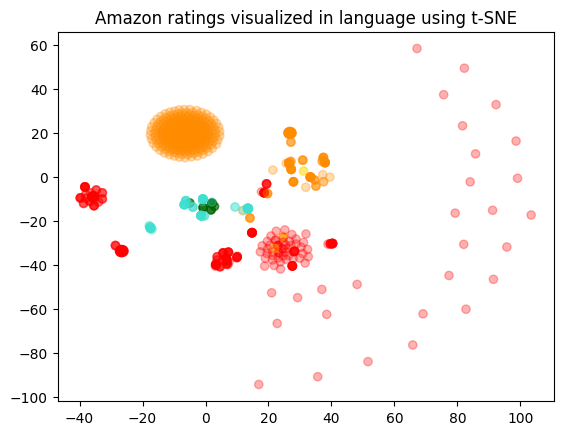

In [188]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

**t-SNE降维后，产生了大约3个大类，其中1个大类的评论大多是负面的。**

## 4. 使用 K-Means 聚类，然后使用 t-SNE 可视化

In [206]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embedded['Cluster'] = kmeans.labels_

/Users/tiger/anaconda3/envs/openai-quickstart/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [207]:
df_embedded['Cluster']

VIN (1-10)
1W9WL21BXA    0
1W9WL21B6A    0
1W9WL21B6A    0
YV4BR0CZ5N    0
7JRBR0FL1N    0
             ..
WA1AAAGE3P    3
WA1VABGE1P    3
WA1VABGE7M    1
WAUUPBFF9H    0
WAUTPBFF5H    0
Name: Cluster, Length: 1000, dtype: int32

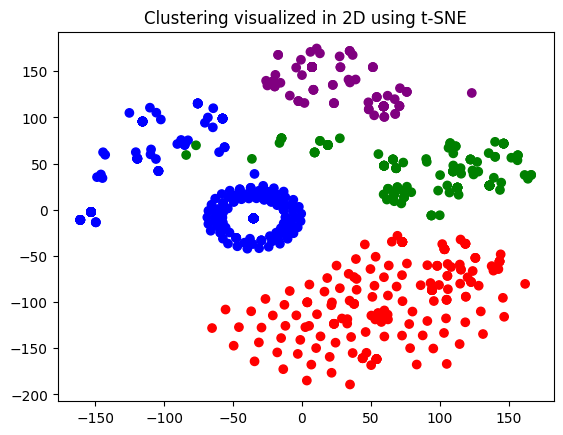

In [208]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embedded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论。**

## 5. 使用 Embedding 进行文本搜索

![cosine](images/cosine.png)

In [192]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
from openai.embeddings_utils import get_embedding, cosine_similarity

In [155]:
type(df_embedded["embedding_vec"][0])

list

In [204]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, combined, n=3, pprint=True):
    product_embedding = get_embedding(
        combined,
        engine="text-embedding-ada-002"
    )
    #print(product_embedding)
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))
    print(df["similarity"])
    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
    )
    print(results)
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [205]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embedded, 'WHEEGO', n=3)

VIN (1-10)
1W9WL21BXA    0.836176
1W9WL21B6A    0.836176
1W9WL21B6A    0.836176
YV4BR0CZ5N    0.745533
7JRBR0FL1N    0.742270
                ...   
WA1AAAGE3P    0.744878
WA1VABGE1P    0.744878
WA1VABGE7M    0.746400
WAUUPBFF9H    0.741026
WAUTPBFF5H    0.741026
Name: similarity, Length: 1000, dtype: float64
            Model Year                  Make   Model  \
VIN (1-10)                                             
1W9WL21BXA        2010  WHEEGO ELECTRIC CARS  WHEEGO   
1W9WL21B6A        2010  WHEEGO ELECTRIC CARS  WHEEGO   
1W9WL21B6A        2010  WHEEGO ELECTRIC CARS  WHEEGO   

                             Electric Vehicle Type  \
VIN (1-10)                                           
1W9WL21BXA  Plug-in Hybrid Electric Vehicle (PHEV)   
1W9WL21B6A  Plug-in Hybrid Electric Vehicle (PHEV)   
1W9WL21B6A  Plug-in Hybrid Electric Vehicle (PHEV)   

           Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
VIN (1-10)                                               

In [195]:
df_embedded['Cluster']

VIN (1-10)
1W9WL21BXA    0
1W9WL21B6A    0
1W9WL21B6A    0
YV4BR0CZ5N    7
7JRBR0FL1N    7
             ..
WA1AAAGE3P    2
WA1VABGE1P    2
WA1VABGE7M    3
WAUUPBFF9H    7
WAUTPBFF5H    7
Name: Cluster, Length: 1000, dtype: int32

In [196]:
# 选一条类别3的评论
df_embedded['combined'][0]

'Model: WHEEGO; EV Type: Plug-in Hybrid Electric Vehicle (PHEV); Clean: Clean Alternative Fuel Vehicle Eligible; Range: 100'

In [52]:
res = search_reviews(df_embedded, df_embedded['combined'][0], n=3)

Model Year

Make

Electric Vehicle Type

Clean Alternative Fuel Vehicle (CAFV) Eligibility

Electric Utility

combined

n_tokens

embedding

embedding_vec

Cluster

similarity



In [114]:
res = search_reviews(df_embedded, 'dog food', n=3)

Healthy Dog Food:  This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

Doggy snacks:  My dog loves these snacks. However they are made in China and as far as I am concerned, suspect!!!! I found an abundance of American made ,human grade chicken dog snacks. Just Google fo

Dogs Love Them!:  My Maltese and Cavalier King Charles love these treats!  I feel good about feeding them a healthier treat.<br />Not made in China!



In [115]:
res = search_reviews(df_embedded, 'awful', n=5)

God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  On

Disappointed:  The metal cover has severely disformed. And most of the cookies inside have been crushed into small pieces. Shopping experience is awful. I'll never buy it online again.

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate a

Arrived in pieces:  Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.

Awesome:  They arrived before the expected time and were of fantastic quality. Would recommend to any one looking for a awesome treat

